In [52]:
%run ./imports_models.py
%run ./dataset_preparation_v2.ipynb
%run -i ./utils.py

Stored 'df_complete' (DataFrame)
Stored 'df_grouped_dates' (DataFrame)
Stored 'series_grouped_dates' (Series)
Stored 'pandas_dataframe_groupby_site' (DataFrameGroupBy)
Stored 'sites_names' (list)


In [53]:
PATH_SERIALIZER = './../serialized_files/'
PATH = '../../BDForecasting_V2/'
PATH_IMG = './images/'

# Data

In [54]:
# %store -r df_grouped_dates
# %store -r series_grouped_dates
# %store -r pandas_dataframe_groupby_site
# %store -r sites_names

# Prepare Timeseries, Train and Forecast by group

* If all_sites is <strong>False</strong>, just one model will be trained with the specific group selected in site_index. 
* If all_sites is <strong>True</strong>, multiple models will be trained for all groups in dataset.

In [55]:
all_sites = False
site_index = 47
sites = []

if all_sites:
    sites = sites_names
else:
    sites = [sites_names[site_index]]

In [56]:
groups_info = {'timeseries':[],
               'tuning_results':[],
               'models':[],
               'forecasts':[],
               'scaler':[]}
exec_times_info = {'tuning_exec_times':[],
                   'training_exec_times':[],
                   'forecast_exec_times':[]}
overall_exec_time = 0

In [99]:
# import pickle
# pickle.dump([groups_info, exec_times_info],open('dummy_arima_group_times_info.pkl','wb'))

In [57]:
# site_2 = sites_names[0]
# site_df_2 = pandas_dataframe_groupby_site.get_group(site_2)

# site_series_data_2 = site_df_2['OCCUPANCY_COUNT']
# site_series_data_2.index = series_grouped_dates.index

# site_series_data_3 = prepare_timeserie_df(site_df_2, pd_series=True, series_index=series_grouped_dates.index)
# site_series_train_2 = site_series_data_3[:16790]
# site_series_test_2 = site_series_data_3[16790:]

In [88]:
cut_final = 4197

In [89]:
print('Multiple Training and Forecasting %s ...\n'%sites_names[site_index])

start_time_overall = time.time()
for site in tqdm(sites):
    print('\033[1m' + 'Group %s'%(site) + '\033[0m')
    site_df = pandas_dataframe_groupby_site.get_group(site)
    scaled_data = prepare_timeserie_df(site_df, pd_series=True, series_index=series_grouped_dates.index)
    scaler = scaled_data[1]
    site_series_data = scaled_data[0]
    site_series_data = site_series_data[:cut_final]
    rows_len = site_series_data.shape[0]
    training_size = 0.7
    site_series_train = site_series_data[:int(rows_len*training_size)]
    site_series_test = site_series_data[int(rows_len*training_size):]
    
    
    print('Tuning...')
    start_time_tuning = time.time()
    site_best_model = hyperparameter_tuning_arima(site_series_train, 
                                                  max_p_P=(5,5), 
                                                  max_d_D=(3,3), 
                                                  max_q_Q=(10,10))
    tuning_exec_time = time.time() - start_time_tuning
    print("best model --> (p, d, q):", site_best_model.order, 
          " and  (P, D, Q, s):", site_best_model.seasonal_order)
    print("--- Tuning ended at %s seconds ---" % (tuning_exec_time))
    

    print('Training model...')
    start_time_training = time.time()
    site_model = sm.tsa.statespace.SARIMAX(site_series_train,
                                           order=site_best_model.order,
                                           seasonal_order=site_best_model.seasonal_order,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False
                                           ).fit()
    training_exec_time = time.time() - start_time_training
    print("--- Training ended at %s seconds ---" % (training_exec_time))
    
    
    print('Forecasting...')
    start_time_forecast = time.time()
    site_forecast = site_model.predict(start=len(site_series_train), 
                                       end=len(site_series_train)+len(site_series_test)-1,
                                       exog=None,
                                       dynamic=False)
    forecast_exec_time = time.time() - start_time_forecast
    print("--- Forecast ended at %s seconds ---\n" % (forecast_exec_time))
    
    
    exec_times_info['tuning_exec_times'].append(tuning_exec_time)
    exec_times_info['training_exec_times'].append(training_exec_time)
    exec_times_info['forecast_exec_times'].append(forecast_exec_time)
    
    groups_info['timeseries'].append(site_series_data)
    groups_info['tuning_results'].append(site_best_model)
    groups_info['models'].append(site_model)
    groups_info['forecasts'].append(site_forecast)
    groups_info['scaler'].append(scaler)
    
    
overall_exec_time = time.time() - start_time_overall
print("Multiple Training and Forecasting ended at--- %s seconds ---" % (overall_exec_time))

Multiple Training and Forecasting S&C-AEB: CB&WD&A-PU-DE ...



  0%|          | 0/1 [00:00<?, ?it/s]

Group S&C-AEB: CB&WD&A-PU-DE
Tuning...
best model --> (p, d, q): (5, 0, 1)  and  (P, D, Q, s): (0, 0, 7, 7)
--- Tuning ended at 3886.0028860569 seconds ---
Training model...
--- Training ended at 47.748323917388916 seconds ---
Forecasting...
--- Forecast ended at 0.25132274627685547 seconds ---

Multiple Training and Forecasting ended at--- 3934.1022477149963 seconds ---


In [42]:
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)
#     return pd.Series(diff)

# X = site_df.reset_index()['OCCUPANCY_COUNT'].values
# diff = difference(X)
# diff

# diff.index = site_df[:-1].index

# diff.plot(figsize=(20,5))

# site_df.plot(figsize=(20,5))

# Execution times info

Times for each group (unit: segs)

In [90]:
pd.DataFrame(exec_times_info)

,tuning_exec_times,training_exec_times,forecast_exec_times
0,1497.217096,36.769027,0.474076
1,354.511845,2.614750,0.228811
2,219.235899,2.521635,0.145571
3,3886.002886,47.748324,0.251323


Overall groups execution time (unit: segs)

In [91]:
overall_exec_time

3934.1022477149963

# Load group info

In [92]:
index_temp = 3

In [93]:
print('%s has been selected'%sites_names[site_index])
# if not all_sites:
#     site_index = 0

model_site = groups_info['models'][index_temp]
forecast_site = groups_info['forecasts'][index_temp]
df_data_site = groups_info['timeseries'][index_temp]
df_data_train_site = df_data_site[:int(rows_len*training_size)]
df_data_test_site = df_data_site[int(rows_len*training_size):]
y_true_scaled = pd.DataFrame(df_data_test_site)

S&C-AEB: CB&WD&A-PU-DE has been selected


In [94]:
y_true = scaler.inverse_transform(y_true_scaled.values.reshape(-1,1))

#### Model info

In [95]:
print(model_site.summary())

                                               SARIMAX Results                                               
Dep. Variable:                                       OCCUPANCY_COUNT   No. Observations:                 2937
Model:             SARIMAX(5, 0, 1)x(0, 0, [1, 2, 3, 4, 5, 6, 7], 7)   Log Likelihood                1814.945
Date:                                               Tue, 16 Mar 2021   AIC                          -3601.890
Time:                                                       16:20:11   BIC                          -3518.343
Sample:                                                   01-01-2018   HQIC                         -3571.779
                                                        - 05-08-2018                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

# Forecast evaluation metrics

In [96]:
y_pred_scaled = forecast_site.copy()
y_pred = scaler.inverse_transform(y_pred_scaled.values.reshape(-1,1))

In [97]:
# y_true_scaled = df_data_test_site

performance_metrics_forecast = get_performance_metrics_forecast(y_true, y_pred)
mae_forecast = performance_metrics_forecast[0]
mse_forecast = performance_metrics_forecast[1]
rmse_forecast = performance_metrics_forecast[2]

In [98]:
forecast_performace_site = pd.DataFrame({'mse_forecast_site':mse_forecast, 
                                         'rmse_forecast_site':rmse_forecast, 
                                         'mae_forecast_site':mae_forecast},
                                          index=[0])
forecast_performace_site

,mse_forecast_site,rmse_forecast_site,mae_forecast_site
0,5.68297,4.518789,32.296148


# Visualizations

#### Train and test

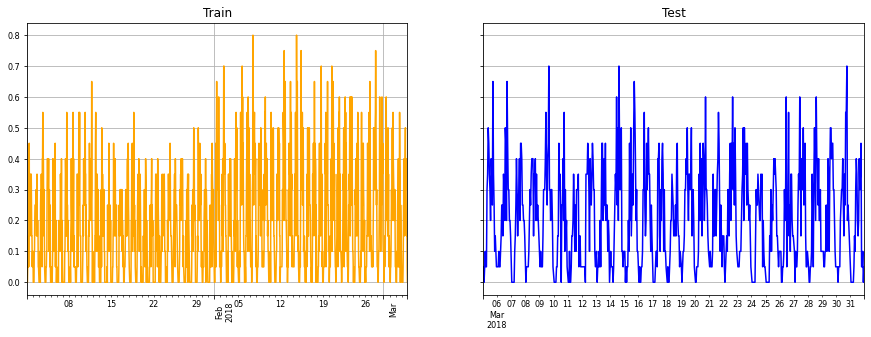

In [30]:
plot_train_test(df_data_train_site, df_data_test_site, fontsize=8, rotation=90)

#### Diagnostics

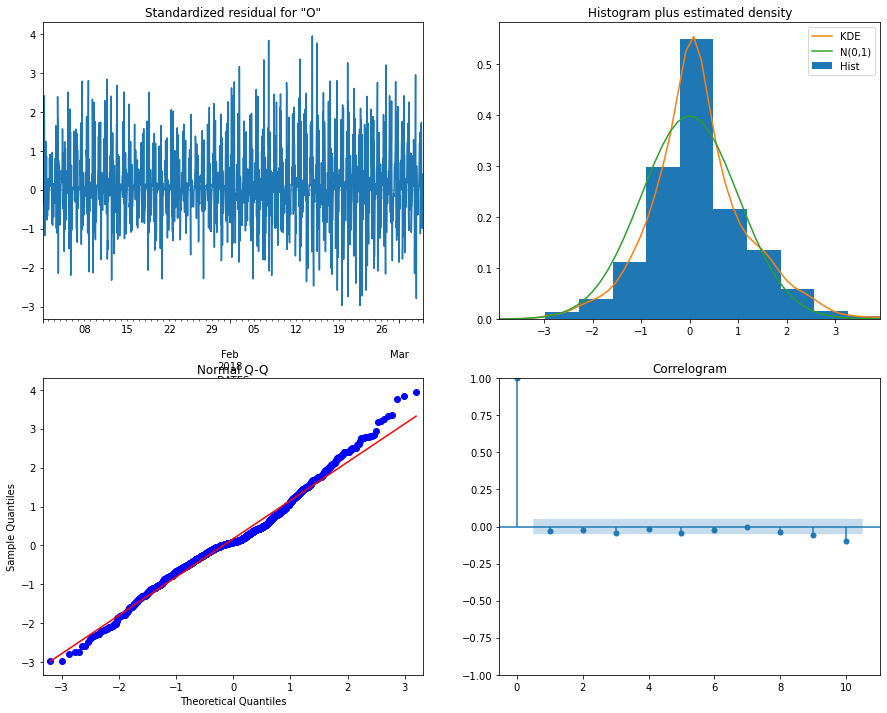

In [31]:
model_site.plot_diagnostics(figsize=(15, 12))
plt.savefig("{}sarima_forecast_diagnosis.png".format(PATH_IMG), format="png")
plt.show()

### Plot overall

In [32]:
pred = model_site.get_prediction(start=len(df_data_train_site), 
                              end=len(df_data_train_site)+len(df_data_test_site)-1,
                              dynamic=False)

pred_ci = pred.conf_int()
pred_ci.loc[:, 'lower OCCUPANCY_COUNT'] = pred_ci.loc[:, 'lower OCCUPANCY_COUNT'].apply(lambda x: 0 if x<0 else x)
pred_ci.loc[:, 'upper OCCUPANCY_COUNT'] = pred_ci.loc[:, 'upper OCCUPANCY_COUNT'].apply(lambda x: 1 if x>1 else x)

In [33]:
pred_ci_mean = pred_ci.loc[:, 'lower OCCUPANCY_COUNT'] + pred_ci.loc[:, 'upper OCCUPANCY_COUNT']
pred_ci_mean = pred_ci_mean.apply(lambda x: x/2)

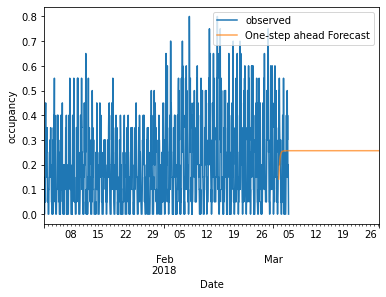

In [34]:
ax = df_data_train_site.plot(label='observed')
pred_ci_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('occupancy')
plt.legend()

plt.show()

# ARIMA

# Forecasting

In [95]:
model = ARIMA(df_data_train_site, order=groups_info['tuning_results'][0].order)
model_fit = model.fit()
output = model_fit.forecast()
yhat = output[0]
obs = test[t]
print('predicted=%f, expected=%f' % (yhat, obs))

C:\Users\59399\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



NameError: name 'test' is not defined

# Model evaluation

In [ ]:
rmse_arima = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# plot forecasts against actual outcomes
lower_limit = 100
upper_limit = 200
plt.figure(figsize=(30,10))
plt.plot(test[lower_limit:upper_limit])
plt.plot(predictions[:limit], 
         color='red')
plt.show()